# Introduction to Solar Radiation

This notebook works through a few simple equations and concepts from the lectures. Code is written in R. The notebook consists of text and bits of code. For code cells, highlight the cell and press 'Run' or press Shift+Enter to execute the code. As we go along some bits will rely on certain packages or earlier values and functions, so if you're getting errors make sure you've executed the code in previous cells first. If you prefer to see just the scripts they're also available on my GitHub.

This first bit loads a package that we'll be using for plotting. Make sure it's executed first:

In [10]:
library(ggplot2)
library(tidyr)

To get a feel for equations, please feel free to play with the values as much as you like.

## 1 - Radiation Basics

#### Calculate frequency from wavelength and the energy of a photon, etc.

In [13]:
# f = c/lambda

lambda <- 0.55 * 10^(-6) # enter wavelength in um
c <- 3*10^8 # approximation to speed of light
f <- c/lambda # calculate frequency
print(paste("Frequency of wavelength",lambda,'=',f))

[1] "Frequency of wavelength 5.5e-07 = 545454545454545"


In [12]:

# calculate energy of a photon
# e = hf

h <- 6.63 * 10^(-34) # Planck's constant
e <- h*f # calculate energy per photon
print(e)

[1] 3.616364e-19



Q: How does the frequency, wavelength, and energy per photon change when we move to the infrared (e.g. 4 um) waveband? How about the ultraviolet (e.g. 0.1 um)?
Modify the code above and re-run it

#### Calculate total energy reaching the surface of Freiburg over a year:

In [16]:
avgIrradiance <- 130 # W/m2
sPerYear <- 60*60*24*365 # number of seconds per year
joules <- avgIrradiance * sPerYear # joules at Freiburg surface

GJ <- joules / 1000000000 # convert to gigajoules
print(paste(GJ,"GigaJoules"))

kWh <- joules / (3600*1000) # convert to kWh
print(paste(kWh,"kWh"))

[1] "4.09968 GigaJoules"
[1] "1138.8 kWh"


Q: The flux density of solar radiation at the edge of Earth's atmosphere normal to the equator is ~1361 W/m2. How many GJ is this over a year?
How many kWh?

#### Relate the sun's surface temperature (5778 K) to its wavelength of maximum emission:

In [18]:

b <- 2.8978e-3 # Constant
TSun <- 5778 # Kelvin
lambdaMax <- b/TSun
lambdaMax <- lambdaMax * 1000000 # convert to um
print(paste("The Sun's wavelength of maximum emission is",lambdaMax,"um"))

[1] "The Sun's wavelength of maximum emission is 0.501523018345448 um"


Q: Seen from space Earth's radiative (effective) temperature is roughly 255 K (-18 deg.C). What is Earth's wavelength of max emission?


## 2 - Solar Position

#### Calculate the solar declination

The following section uses functions. These are reusable pieces of code that we can call to perform calculations we intend to repeat. The function definition names the function, specifies what input variables it requires to run, what code is to be executed, and what value is to be returned. As an example, the following two functions convert radians to degrees and vice versa

In [19]:
# convert radians to degrees for coherence and vice-verse
# Execute this code to define these functions before moving on
radToDeg <- function(r) {return(r * (180/pi))}
degToRad <- function(deg) {return(deg*(pi/180))}

Once the above code is executed, those functions are defined and we can use them at our leisure. You can play verify they work by executing them here:

In [23]:
angle <- 180
rad <- pi
degToRad(angle)
radToDeg(rad)

[1] 3.141593

[1] 180

This function calculates the solar declination:

In [24]:
# function for calculating the solar declination
getSolarDec <- function(yd) {
  gamma <- (2*pi)/365 * (yd-1)
  delta <- 0.006918 - 0.399912*cos(gamma) + 0.070257*sin(gamma) - 
    0.006758*cos(2*gamma) + 0.000907*sin(2*gamma) - 
    0.002697*cos(3*gamma) + 0.00148*sin(3*gamma)
  return(delta)
}

 Enter a day of the year (as integer 1-365) below and calculate the solar declination

In [25]:
# calculate the solar declination on, e.g., your birthday
yd <- 55 # adjust to your birthday

delta <- getSolarDec(yd)
print(radToDeg(delta))

[1] -9.749847


Q: How does solar declination vary through the year?

A: We can calculate solar declination for every day and plot it:

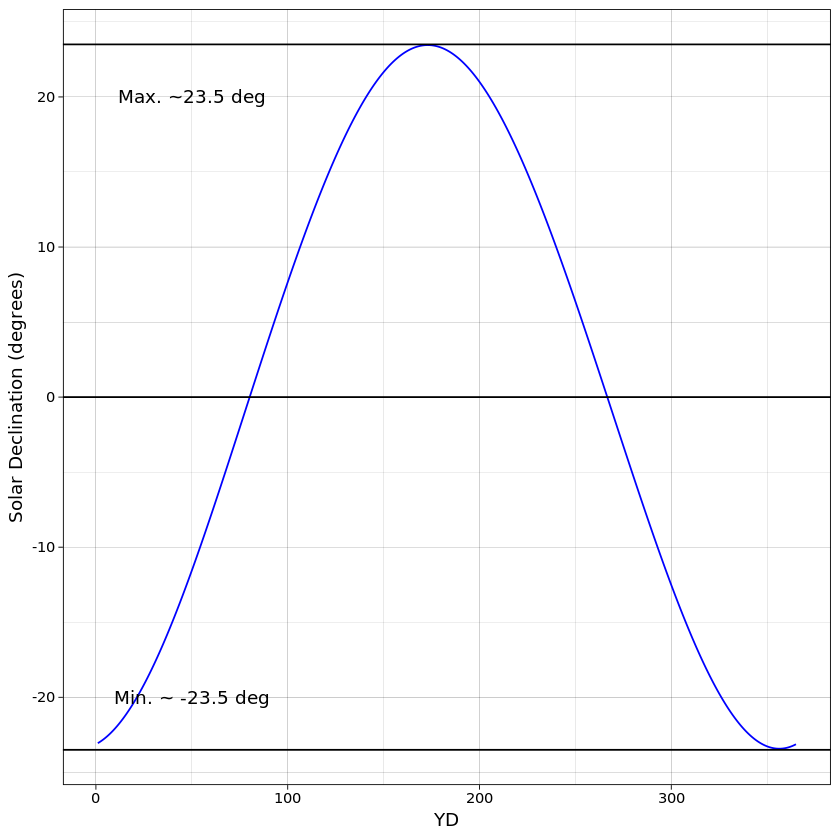

In [26]:
ydVector <- seq(1,365,1) # list of integer days
deltaVector <- radToDeg(getSolarDec(ydVector)) # corresponding declinations

# put in a plottable form and plot
plotFrame <- as.data.frame(cbind(ydVector,deltaVector)) 
ggplot(plotFrame, aes(x=ydVector, y=deltaVector)) + geom_line(col='blue') + theme_linedraw() +
  labs(x="YD", y="Solar Declination (degrees)") + geom_hline(yintercept=0) +
  geom_hline(yintercept=23.5) + geom_hline(yintercept=-23.5) +
  annotate("text", x=50, y=20, label="Max. ~23.5 deg") +
  annotate("text", x=50, y=-20, label="Min. ~ -23.5 deg")

Note where the extreme values occur: they do not line up with calendar year! What does a comparison to the simplified calculation look like?

#### It's 14:30 on March 23, 2021 in Freiburg. Where's the Sun?

The following functions implement the Low Accuracy equations

In [27]:

getGamma <- function(yd) {return((2*pi)/365 * (yd-1))} # returned in radians!

getDelta <- function(gamma) {
  delta <- 0.006918 - 0.399912*cos(gamma) + 0.070257*sin(gamma) - 
    0.006758*cos(2*gamma) + 0.000907*sin(2*gamma) - 
    0.002697*cos(3*gamma) + 0.00148*sin(3*gamma)
  return(delta) # returned in radians!
}


getEqnofTime <- function(gamma) {
  dTlat <- 229.18 * (0.000075 + 0.001868*cos(gamma) -
                        0.032077*sin(gamma) - 0.014615*cos(2*gamma)-
                        0.040849*sin(2*gamma))
  return(dTlat) # returned in MINUTES!
}


getTOffset <- function(dTlat, lambda, epsilon) {
  To <- dTlat + 4*lambda - 60*epsilon
  return(To) # returned in MINUTES!
}


getTlat <- function(lst, To) { # strip text format in to integers
  H <- as.numeric(unlist(strsplit(lst,"\\:"))[1])
  M <- as.numeric(unlist(strsplit(lst,"\\:"))[2])
  S <- as.numeric(unlist(strsplit(lst,"\\:"))[3])
  Tsol <- H*60 + M + S/60 + To # returned in MINUTES!
}


getHourAngle <- function(Tsol) {
  return((Tsol/4)-180) # returned in DEGREES!
}


getZenith <- function(phi, delta, h) {
  phi <- degToRad(phi)
  h <- degToRad(h)
  cosZ <- sin(phi)*sin(delta)+cos(phi)*cos(delta)*cos(h)
  zenith <- radToDeg(acos(cosZ))
  return(zenith) # returned in DEGREES!
}


getAzimuth <- function(phi, Z, delta) {
  # I never got to this - give it a go!
  }

Input the necessary information:

In [28]:
# these values are looked up / determined from Google
yd <- 82 # year day
lambda <- 7.8 # longitude
phi <- 48 # latitude
epsilon <- 1
lst <- "12:30:00"

And determine the angles:

In [31]:

# these values are calculated as intermediate steps
gamma <- getGamma(yd) # radians
delta <- getDelta(gamma) # radians
dTlat <- getEqnofTime(gamma) # minutes
To <- getTOffset(dTlat, lambda, epsilon) # minutes
Tlat <- getTlat(lst, To) # minutes
h <- getHourAngle(Tlat) # degrees

# determine solar angles
zenithAngle <- getZenith(phi, delta, h) # in deg.
azimuthAngle <- getAzimuth(phi, Z, delta)

print(zenithAngle)
print(azimuthAngle) # not finished :(

[1] 47.29466
NULL


## 3 - Extraterrestrial Solar Radiation

#### How much energy is emitted by the Sun?

In [33]:
sunTemp <- 5778 # Kelvin
sigma <- 5.67e-8 # S-B Constant
totalEmit <- sigma * sunTemp ** 4 # calculate integral emittance
print(paste(totalEmit,"W/m2"))

[1] "63196526.5460292 W/m2"


Q: The star 63 Ophiuchi has a measured surface temperature of approximately 34,000 K -> what is the radiation flux density at the surface of this star?

#### How much of this solar radiation reaches the tropopause?

In [37]:
r1 <- 694250 # radius of the Sun in km
r2 <- 149600000 # ~mean radius of Earth's orbit
E2 <- totalEmit * (r1/r2)**2 # make sure totalEmit is still valid for 5778 K and not 34,000 K
print(paste(round(E2,2),"W/m2"))

[1] "1361.01 W/m2"


Q: Mercury has a mean distance of 58,000,000 km from the Sun. What is its solar constant?


#### Determine the variation in insolation caused by Earth's eccentric orbit

In [38]:
# functions

getGamma <- function(yd) {return((2*pi)/365 * (yd-1))} # returned in radians!

orbitRatio <- function(gamma, solarConst) {
  # equates the mean to real orbit using the inverse square law
  ratio <- 1.00011 + 0.034221*cos(gamma) + 0.001280*sin(gamma) +
    0.000719*cos(2*gamma) + 0.000077*sin(2*gamma)
  insol <- solarConst * ratio
  return(insol)
}

In [39]:
# inputs
solarConst <- 1361.012
days <- seq(1,365,1) # simple list of days

gammaDays <- getGamma(days) # calculate fractional year
solarRad <- orbitRatio(gammaDays, solarConst) # apply the inverse square law to each fractional day

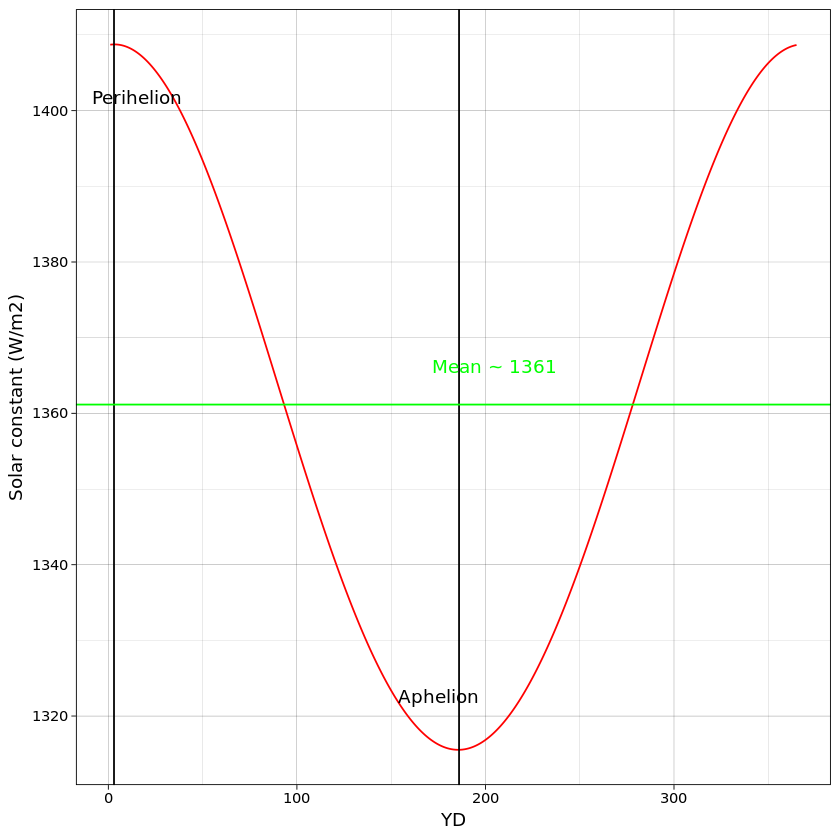

In [40]:
# for plotting
insolation <- as.data.frame(cbind(days,solarRad))

# determine perihelion and aphelion as days w/ max and min insolation
perihelion <- insolation$days[insolation$solarRad == max(insolation$solarRad)]
aphelion <- insolation$days[insolation$solarRad == min(insolation$solarRad)]
  
# plot the results
ggplot(insolation, aes(x=days, y=solarRad)) + geom_line(col="red") + theme_linedraw() +
  labs(x="YD", y="Solar constant (W/m2)") + geom_vline(xintercept=perihelion) + geom_vline(xintercept=aphelion) +
  geom_hline(yintercept=mean(insolation$solarRad), col="green") +
  annotate("text", x=15, y=insolation$solarRad[perihelion]-7, label="Perihelion") +
  annotate("text", x=175, y=insolation$solarRad[aphelion]+7, label="Aphelion") +
  annotate("text", x=205, y=mean(insolation$solarRad)+5, label="Mean ~ 1361", col="green")

#### Examine how radiation is distributed between the poles and the equator

Assume: mean insolation at solar noon on an equinox

In [41]:
# functions
degToRad <- function(deg) {return(deg*(pi/180))}

cosineLaw <- function(z, solarConst) { # implement cosine law of illumination
  return(solarConst*cos(degToRad(z)))
}

latitudes <- seq(-90,90,1) # list of latitudes
solarConst <- 1361 # in W/m2
insolationDistribution <- cosineLaw(latitudes, solarConst) # apply cosine law to each latitude


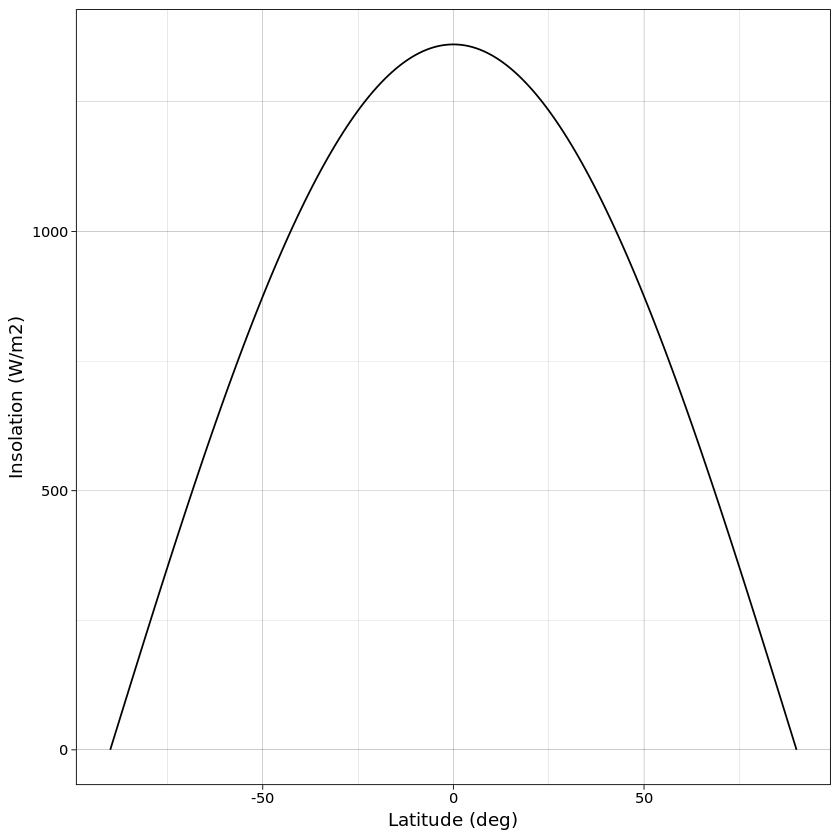

In [42]:
# plot
distribution <- as.data.frame(cbind(latitudes,insolationDistribution))
ggplot(distribution, aes(x=latitudes, y=insolationDistribution)) + geom_line() + theme_linedraw() +
  labs(x="Latitude (deg)", y="Insolation (W/m2)")

#### How does this change at the perihelion and aphelion?

Warning message:
“Removed 46 rows containing missing values (geom_path).”

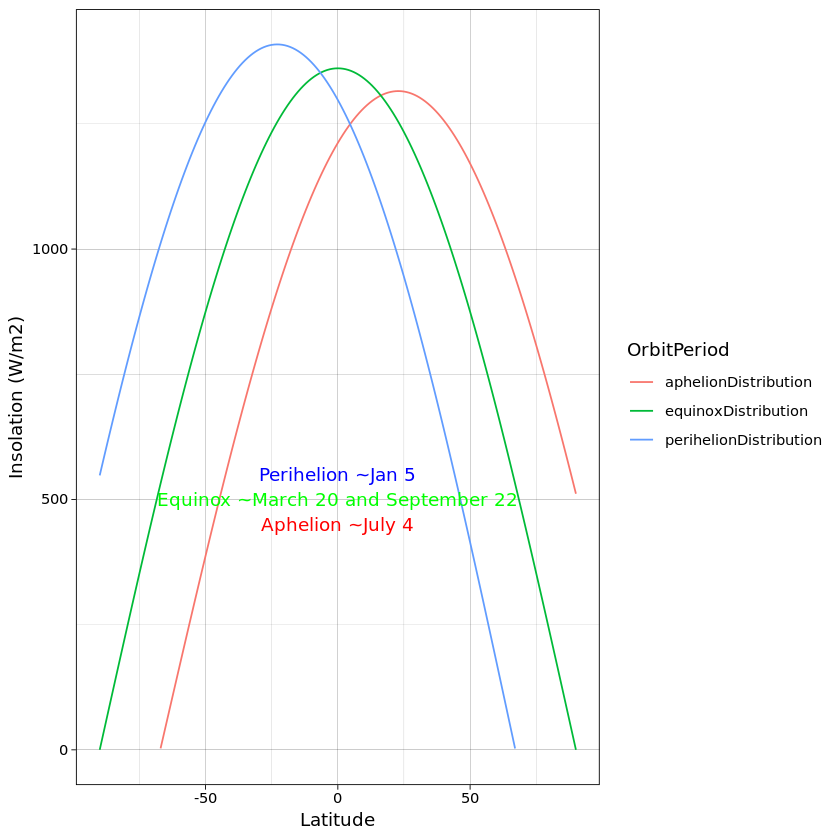

In [43]:
# Get the solar declination at perihelion and aphelion
perihelionDeclination <- radToDeg(getDelta(getGamma(perihelion)))
aphelionDeclination <- radToDeg(getDelta(getGamma(aphelion)))

# get the insolation at tropopause for perihelion and aphelion
perihelionKParallel <- max(insolation$solarRad)
aphelionKParallel <- min(insolation$solarRad)

# calculate cosine law
perihelionDistribution <- cosineLaw(latitudes-perihelionDeclination, perihelionKParallel)
aphelionDistribution <- cosineLaw(latitudes-aphelionDeclination, aphelionKParallel)

perihelionDistribution[perihelionDistribution < 0] <- NaN # handle negative values
aphelionDistribution[aphelionDistribution < 0] <- NaN

# organising
equinoxDistribution <- insolationDistribution
distributionTwo <- as.data.frame(cbind(latitudes,equinoxDistribution,perihelionDistribution,aphelionDistribution))
distributionTwo <- distributionTwo %>% gather("OrbitPeriod", "FluxDensity", -latitudes)

# plot
ggplot(distributionTwo, aes(x=latitudes, y=FluxDensity, col=OrbitPeriod)) + geom_line() + theme_linedraw() +
  labs(x="Latitude", y="Insolation (W/m2)") +
  annotate("text", x=0, y=550, label="Perihelion ~Jan 5", col="blue") +
  annotate("text", x=0, y=500, label="Equinox ~March 20 and September 22", col="green") +
  annotate("text", x=0, y=450, label="Aphelion ~July 4", col="red")